In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime

<Axes: xlabel='Date'>

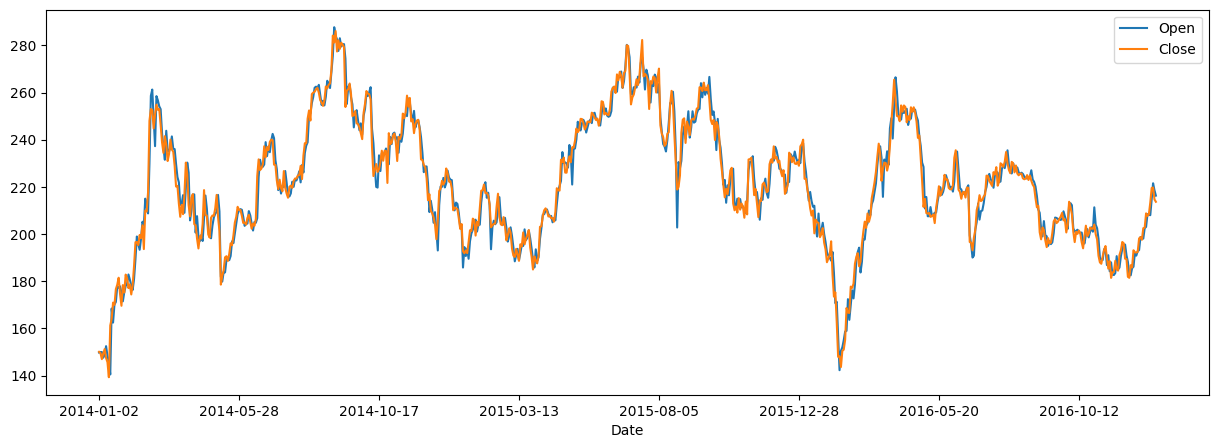

In [115]:
tesla = pd.read_csv('data/TSLA_data.csv')
tesla2 = tesla[['Date', 'Open', 'Close']]
tesla2 = tesla2.loc[884:1639]
tesla2.plot(x='Date', y=['Open', 'Close'], figsize=(15, 5))

In [21]:
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [22]:
tesla = tesla[['Date', 'Close']]

In [23]:
tesla.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [24]:
# Converting the date series to a datetime object
tesla.Date = pd.to_datetime(tesla.Date, format = '%Y/%m/%d')

In [25]:
# Setting the index 
plot_tesla = tesla.set_index('Date')

# Plot of the Tesla stock price dataset

<Axes: xlabel='Date'>

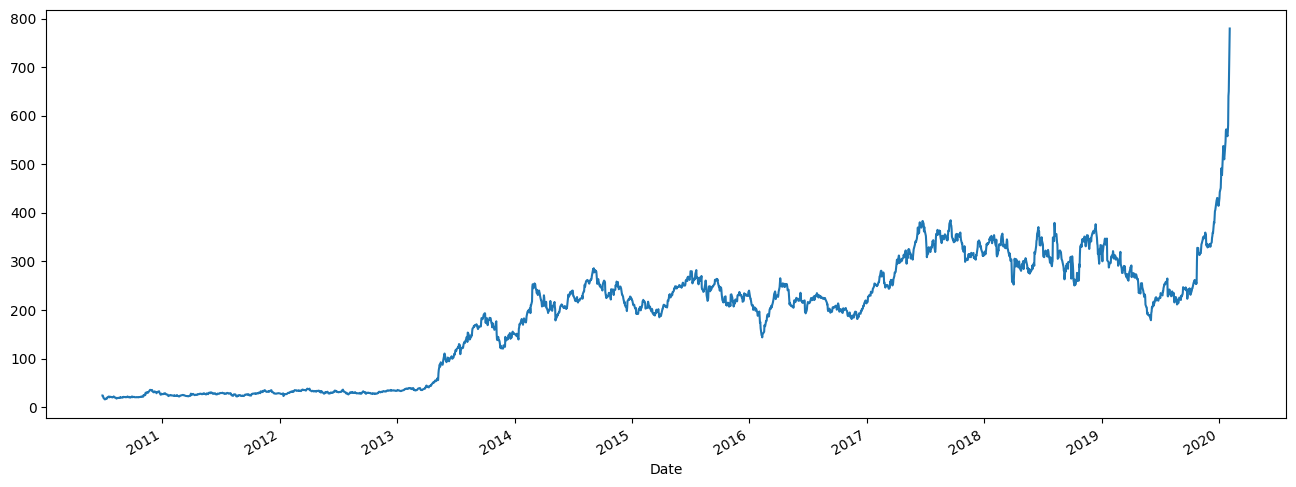

In [26]:
plot_tesla['Close'].plot(figsize=(16,6))

# Selecting the portion of dataset we want to predict
Upon visual inspection, the time series is roughly stationary from the period of 2014 through the end of 2016, so let's reduce the dataset to 2014 through 2016. Stationarity means that the time series has a constant mean and variance over a certain time horizon. 

Start date: 1/1/14 -> index = 884

End date: 12/31/16 -> index = 1639

In [27]:
new_tesla = tesla.loc[884:1639]

In [28]:
new_tesla.head()

,Date,Close
884,2014-01-02,150.100006
885,2014-01-03,149.559998
886,2014-01-06,147.000000
887,2014-01-07,149.360001
888,2014-01-08,151.279999


In [29]:
new_tesla.tail()

,Date,Close
1635,2016-12-23,213.339996
1636,2016-12-27,219.529999
1637,2016-12-28,219.740005
1638,2016-12-29,214.679993
1639,2016-12-30,213.690002


# Feature Preprocessing
Below, we apply a min-max scaler to the dataset, and then convert it to a supervised learning problem. Basically, you can visualize the conversion in terms of a "sliding window", that divides the dataset into many different windows of length 20 days, that allow us to predict the 21st day. As the window slides from left to right, we are able to use a LSTM model to predict a "future" day from 20 preceding days.

## Min-max Scaling and Train/Test Split

In [31]:
new_tesla_dropped = new_tesla.drop('Date', axis = 1)
new_tesla_dropped = new_tesla_dropped.reset_index(drop = True)
new_tesla_dropped.head()
T = new_tesla_dropped.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))
T

array([[150.1 ],
       [149.56],
       [147.  ],
       [149.36],
       [151.28],
       [147.53],
       [145.72],
       [139.34],
       [161.27],
       [164.13],
       [170.97],
       [170.01],
       [176.68],
       [178.56],
       [181.5 ],
       [174.6 ],
       [169.62],
       [178.38],
       [175.23],
       [182.84],
       [181.41],
       [177.11],
       [178.73],
       [174.42],
       [178.38],
       [186.53],
       [196.56],
       [196.62],
       [195.32],
       [199.63],
       [198.23],
       [203.7 ],
       [193.64],
       [209.97],
       [209.6 ],
       [217.65],
       [248.  ],
       [253.  ],
       [252.54],
       [244.81],
       [250.56],
       [254.84],
       [252.66],
       [252.94],
       [246.21],
       [238.84],
       [234.41],
       [241.49],
       [237.79],
       [230.97],
       [233.98],
       [240.04],
       [235.84],
       [234.91],
       [228.89],
       [220.17],
       [220.44],
       [212.96],
       [207.32

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

In [58]:
# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per week
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [34]:
# Checking to make sure that none of our training set is leaking into the testing set
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

False


In [36]:
# Model imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [37]:
# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

# Building the  LSTM RNN Model
Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [38]:
# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [39]:
filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()

Epoch 1/100


2023-04-07 17:48:19.665764: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/30 [>.............................] - ETA: 14s - loss: 0.2526
Epoch 1: val_loss improved from inf to 0.05109, saving model to saved_models/model_epoch_01.hdf5
30/30 [==============================] - 1s 6ms/step - loss: 0.2578 - val_loss: 0.0511
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1052
Epoch 2: val_loss improved from 0.05109 to 0.00421, saving model to saved_models/model_epoch_02.hdf5
30/30 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0042
Epoch 3/100
24/30 [=======================>......] - ETA: 0s - loss: 0.0183
Epoch 3: val_loss did not improve from 0.00421
30/30 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.0049
Epoch 4/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0423
Epoch 4: val_loss improved from 0.00421 to 0.00388, saving model to saved_models/model_epoch_04.hdf5
30/30 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0039
Epoch 5/100
 

## Why we chose the model at epoch 89
The model at epoch 89 had the most similar training and validation losses, which implies that the model is not doing a lot of over or under fitting. As such, we load that model. 

In [40]:
from keras.models import load_model

best_model = load_model('saved_models/model_epoch_89.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

5/5 [==============================] - 0s 876us/step


In [41]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 583)
Y_hat_test = np.reshape(Y_hat_test, newshape = 131)

Y_train = np.reshape(Y_train, newshape = 583)
Y_test = np.reshape(Y_test, newshape = 131)

# Evaluating Model Performance
## Computing the RMSE for the training and testing sets

In [42]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
7.533529607290774 

Test RMSE is: 
4.840542701079375


## Visualizing the actual vs. predicted stock prices

In [43]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [82]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat

result_df.tail()

,Actual_Y,Predicted_Y
709,208.449995,209.336746
710,213.339990,209.944122
711,219.529992,212.740768
712,219.740005,216.265045
713,214.679991,218.670700


In [117]:
tesla_open = pd.read_csv('data/TSLA_data.csv')[['Open']]
new_tesla_open = tesla_open.loc[884:1639]
new_tesla_open.reset_index(drop = True, inplace = True)
new_tesla_open

,Open
0,149.800003
1,150.000000
2,150.000000
3,147.619995
4,148.850006
...,...
751,208.000000
752,214.880005
753,221.529999
754,218.559998


In [128]:
result_df['Open_Price'] = new_tesla_open
result_df['Actual_Y'] = tesla2['Close'].reset_index(drop = True)
result_df.head()

,Actual_Y,Predicted_Y,Open_Price
0,150.100006,190.035355,149.800003
1,149.559998,190.094711,150.000000
2,147.000000,187.177917,150.000000
3,149.360001,187.175049,147.619995
4,151.279999,186.330902,148.850006


In [129]:
budget = 10000
for i in range(len(result_df)):
    if result_df['Predicted_Y'][i] > result_df['Open_Price'][i]:
        print('Day ', i)
        print('Open price: ', result_df['Open_Price'][i])
        print('Predicted price: ', result_df['Predicted_Y'][i])
        print('Actual price: ', result_df['Actual_Y'][i])
        shares = budget // result_df['Open_Price'][i]
        print("shares bought ", shares)
        budget = budget - shares * result_df['Open_Price'][i]
        print('budget before buying: ', budget)
        budget = budget + shares * result_df['Actual_Y'][i]
        print('budget after buying: ', budget)
print('percentage return ', (budget - 10000) / 10000 * 100)

Day  0
Open price:  149.800003
Predicted price:  190.03535
Actual price:  150.100006
shares bought  66.0
budget before buying:  113.19980199999918
budget after buying:  10019.800197999999
Day  1
Open price:  150.0
Predicted price:  190.09471
Actual price:  149.559998
shares bought  66.0
budget before buying:  119.800197999999
budget after buying:  9990.760065999999
Day  2
Open price:  150.0
Predicted price:  187.17792
Actual price:  147.0
shares bought  66.0
budget before buying:  90.76006599999891
budget after buying:  9792.760065999999
Day  3
Open price:  147.619995
Predicted price:  187.17505
Actual price:  149.360001
shares bought  66.0
budget before buying:  49.8403959999996
budget after buying:  9907.600462
Day  4
Open price:  148.850006
Predicted price:  186.3309
Actual price:  151.279999
shares bought  66.0
budget before buying:  83.50006600000052
budget after buying:  10067.980000000001
Day  5
Open price:  152.5
Predicted price:  186.29485
Actual price:  147.529999
shares boug

<Axes: >

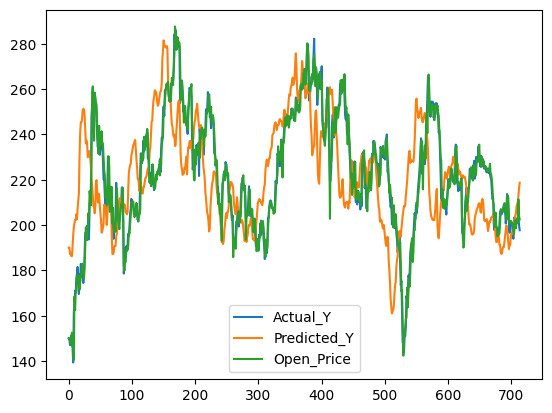

In [130]:
result_df.plot()

## Evaluating income

In [65]:
validate_no_leak = pd.read_csv('data/TSLA_data.csv')
validate_no_leak = validate_no_leak[['Date', 'Close']]
validate_no_leak.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [66]:

validate_no_leak.Date = pd.to_datetime(validate_no_leak.Date, format = '%Y/%m/%d')

<Axes: xlabel='Date'>

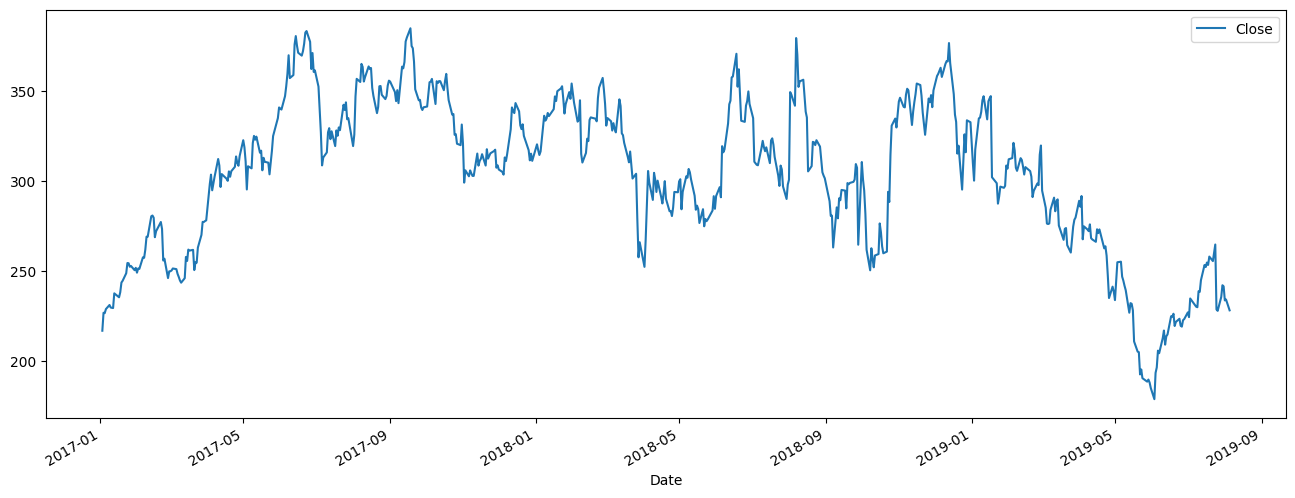

In [67]:
validate_cut = validate_no_leak.loc[1640:2290]
validate_cut.plot(x = 'Date', y = 'Close', figsize = (16,6))

In [68]:
validate_cut_dropped = validate_cut.drop('Date', axis = 1)
validate_cut_dropped = validate_cut_dropped.reset_index(drop = True)
validate_cut_dropped.head()
reshaped = validate_cut_dropped.values
reshaped = reshaped.astype('float32')
reshaped = np.reshape(reshaped, (-1, 1))
reshaped

array([[216.99],
       [226.99],
       [226.75],
       [229.01],
       [231.28],
       [229.87],
       [229.73],
       [229.59],
       [237.75],
       [235.58],
       [238.36],
       [243.76],
       [244.73],
       [248.92],
       [254.61],
       [254.47],
       [252.51],
       [252.95],
       [250.63],
       [251.93],
       [249.24],
       [251.55],
       [251.33],
       [257.77],
       [257.48],
       [262.08],
       [269.2 ],
       [269.23],
       [280.6 ],
       [280.98],
       [279.76],
       [268.95],
       [272.23],
       [277.39],
       [273.51],
       [255.99],
       [257.  ],
       [246.23],
       [249.99],
       [250.02],
       [250.48],
       [251.57],
       [251.21],
       [248.59],
       [246.87],
       [244.9 ],
       [243.69],
       [246.17],
       [258.  ],
       [255.73],
       [262.05],
       [261.5 ],
       [261.92],
       [250.68],
       [255.01],
       [254.78],
       [263.16],
       [270.22],
       [277.45

In [69]:

scaler_to_val = MinMaxScaler(feature_range = (0, 1))
reshaped = scaler_to_val.fit_transform(reshaped)

In [70]:
X_val, Y_val = create_features(reshaped, window_size)
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [134]:
val_predict = best_model.predict(X_val)
val_predicted_transformed = scaler.inverse_transform(val_predict)
#Y_val = scaler.inverse_transform([Y_val])

print(val_predicted_transformed.shape)
print(val_predicted_transformed)


20/20 [==============================] - 0s 1ms/step
(630, 1)
[[197.71262]
 [196.69553]
 [196.66533]
 [196.98912]
 [198.3262 ]
 [198.97021]
 [200.75386]
 [203.69109]
 [205.17119]
 [209.52737]
 [212.03937]
 [212.43233]
 [209.93747]
 [208.8247 ]
 [210.15446]
 [209.83575]
 [203.92693]
 [200.96396]
 [195.77086]
 [193.13942]
 [192.8139 ]
 [192.50446]
 [192.28773]
 [192.31828]
 [191.24542]
 [190.89948]
 [189.85265]
 [188.00688]
 [189.77205]
 [194.6353 ]
 [196.90973]
 [199.1713 ]
 [201.03514]
 [201.30067]
 [199.05354]
 [198.22862]
 [198.68974]
 [200.62558]
 [204.45709]
 [207.98654]
 [210.30838]
 [210.68802]
 [211.2213 ]
 [217.49352]
 [223.36151]
 [222.95491]
 [224.49126]
 [225.52313]
 [228.77164]
 [230.4054 ]
 [226.67783]
 [227.16953]
 [226.65024]
 [225.11044]
 [227.5282 ]
 [226.5325 ]
 [226.07544]
 [228.2471 ]
 [230.764  ]
 [231.01622]
 [229.79413]
 [230.64702]
 [235.48308]
 [236.69919]
 [233.36049]
 [226.97034]
 [226.8975 ]
 [227.7915 ]
 [232.38902]
 [237.7909 ]
 [238.02037]
 [239.18875]
 [

In [136]:
val_predicted_transformed = np.reshape(val_predicted_transformed, newshape = 630)
val_predicted_transformed

array([197.71262, 196.69553, 196.66533, 196.98912, 198.3262 , 198.97021,
       200.75386, 203.69109, 205.17119, 209.52737, 212.03937, 212.43233,
       209.93747, 208.8247 , 210.15446, 209.83575, 203.92693, 200.96396,
       195.77086, 193.13942, 192.8139 , 192.50446, 192.28773, 192.31828,
       191.24542, 190.89948, 189.85265, 188.00688, 189.77205, 194.6353 ,
       196.90973, 199.1713 , 201.03514, 201.30067, 199.05354, 198.22862,
       198.68974, 200.62558, 204.45709, 207.98654, 210.30838, 210.68802,
       211.2213 , 217.49352, 223.36151, 222.95491, 224.49126, 225.52313,
       228.77164, 230.4054 , 226.67783, 227.16953, 226.65024, 225.11044,
       227.5282 , 226.5325 , 226.07544, 228.2471 , 230.764  , 231.01622,
       229.79413, 230.64702, 235.48308, 236.69919, 233.36049, 226.97034,
       226.8975 , 227.7915 , 232.38902, 237.7909 , 238.02037, 239.18875,
       236.55107, 235.22835, 231.17363, 230.83861, 231.02765, 230.96729,
       227.58612, 227.78874, 230.87593, 235.18253, 

In [138]:
to_predict = pd.read_csv('data/TSLA_data.csv')
to_predict = to_predict[['Open', 'Close']]
to_predict = to_predict.loc[1640:2290]
to_predict['Predicted_close'] = val_predicted_transformed
to_predict.head()

ValueError: Length of values (630) does not match length of index (651)